# Open Street Map

By making use of the [OSMnx](https://osmnx.readthedocs.io/en/stable/) library we can fetch [OpenStreetMap](https://www.openstreetmap.org/) data and use it in [MGSurvE](https://github.com/Chipdelmal/MGSurvE)! This time, we will start by loading the library and setting up some of its internal parameters:

In [1]:
# Fix PROJ path ---------------------------------------------------------------
import os; 
os.environ['PROJ_LIB']=r'/opt/conda/pkgs/proj-9.2.1-ha5fc9e9_0/share/proj'
import warnings
from sys import warnoptions
if not warnoptions:
    warnings.simplefilter("ignore")
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=RuntimeWarning)
# Load libraries --------------------------------------------------------------
import osmnx as ox
import numpy as np
import pandas as pd
from math import exp
from copy import deepcopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import MGSurvE as srv
ox.settings.log_console=False
ox.settings.use_cache=True
# Setup data path and ID ------------------------------------------------------
(ID, OUT_PTH) = ('Banfora', './out/')
srv.makeFolder(OUT_PTH)

## Downloading Buildings Footprints

In this example, we will download the data of a section of Banfora, Burkina Faso. To do this, we will center our reference point at the `(110.63524, -4.75195)` coordinates and set an altitude of `250` meters:

In [2]:
(COORDS, DIST) = ((10.63524, -4.75195), 250)
# Scrape building footprints to dataframe -------------------------------------
BLD = ox.features.features_from_point(
    COORDS, tags={'building': True} , dist=DIST
)
NTW = ox.graph_from_point(
    COORDS, dist=DIST, network_type='all',
    retain_all=True, simplify=True, truncate_by_edge=True
)
BLD['centroid_lon'] = [poly.centroid.x for poly in BLD['geometry']]
BLD['centroid_lat'] = [poly.centroid.y for poly in BLD['geometry']]
BLD.reset_index(inplace=True)

/Users/sanchez.hmsc/miniconda3/envs/MGSurvE_Webinar/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE_Webinar/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE_Webinar/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


The `BLD` dataframe contains all the information we need to generate a map of the location and we can, additionally, plot the roads by projecting the `NTW` graph:

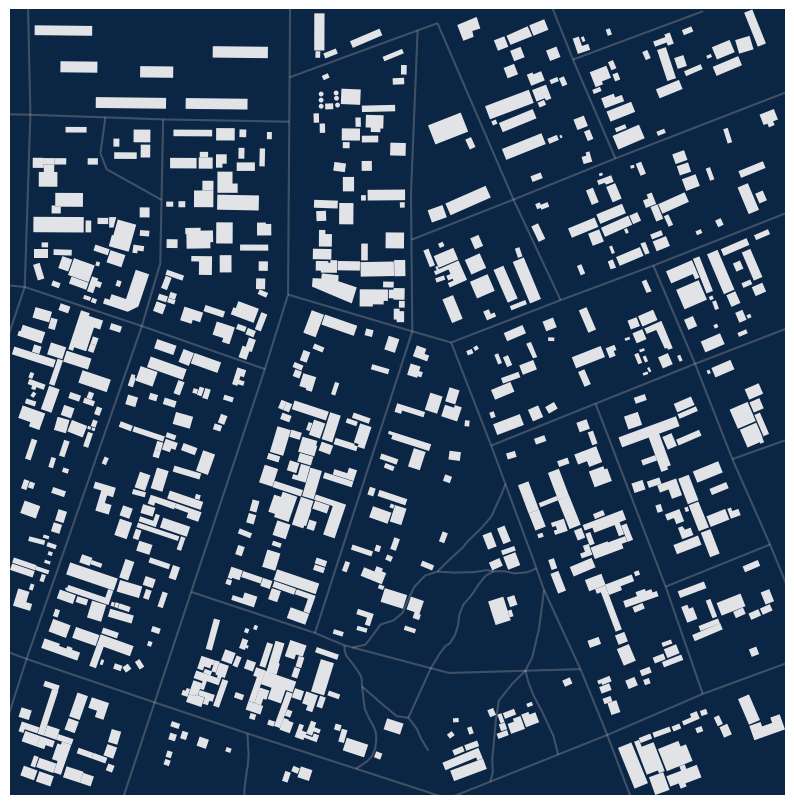

In [3]:
STYLE_BG = {'color': '#0b2545'}
STYLE_BD = {'color': '#faf9f9', 'alpha': 0.900}
STYLE_RD = {'color': '#ede0d4', 'alpha': 0.125, 'width': 1.5}
# Project and plot map --------------------------------------------------------
G = ox.project_graph(NTW, to_crs=ccrs.PlateCarree())
(fig, ax) = ox.plot_graph(
    G, node_size=0, figsize=(10, 100), show=False,
    bgcolor=STYLE_BG['color'], edge_color=STYLE_RD['color'], 
    edge_alpha=STYLE_RD['alpha'], edge_linewidth=STYLE_RD['width']
)
(fig, ax) = ox.plot_footprints(
    BLD, ax=ax, save=False, show=False, close=False,
    bgcolor=STYLE_BG['color'], color=STYLE_BD['color'], 
    alpha=STYLE_BD['alpha']
)

## Generating MGSurvE Landscape

If we wanted to make use of our data in [MGSurvE](https://github.com/Chipdelmal/MGSurvE), one simple way we can go about it is by using the `centroid_lon` and `centroid_lat` to generate our migration matrix and landscape:

In [4]:
lonLats = np.array(list(zip(BLD['centroid_lon'], BLD['centroid_lat'])))
migDst = srv.calcDistanceMatrix(lonLats, distFun=srv.haversineDistance)

This time, we will define a custom exponential kernel. To do this we just need to define a function that takes the distance matrix as an argument, applies a function upon it based on the distance between every pair-wise combination of points (an exponential decay one, in this case), and returns a row-normalized migration probability matrix:

In [5]:
# Defining our custom migration kernel ----------------------------------------
def exponentialKernel(distMat, decay):
    coordsNum = len(distMat)
    migrMat = np.empty((coordsNum, coordsNum))
    for (i, row) in enumerate(distMat):
        for (j, dst) in enumerate(row):
            migrMat[i][j] = exp(-decay*dst)
        for j in range(len(row)):
            if np.isnan(migrMat[i][j]):
                migrMat[i][j] = 0
    tauN = normalize(migrMat, axis=1, norm='l1')
    return np.array(tauN)
# Calculating the full migration matrix ---------------------------------------
MEAN_LIFETIME_DISPERSAL = 25
migMat = exponentialKernel(migDst, 1/MEAN_LIFETIME_DISPERSAL)

We now generate our sites dataframe:

In [6]:
# Generate sites dataframe ----------------------------------------------------
sites = pd.DataFrame(lonLats, columns=['lon', 'lat'])
sites['t'] = [0]*sites.shape[0]
# Get the bounding box and centroid -------------------------------------------
BBOX = (
    (min(sites['lon']), max(sites['lon'])),
    (min(sites['lat']), max(sites['lat']))
)
CNTR = [i[0]+(i[1]-i[0])/2 for i in BBOX]

And define the traps we want to optimize:

In [7]:
TRPS_NUM = 5
(initLon, initLat) = (COORDS[0]*TRPS_NUM, COORDS[1]*TRPS_NUM)
sid = [0]*TRPS_NUM
traps = pd.DataFrame({
    'sid': sid,
    'lon': initLon, 'lat': initLat, 
    't': [0]*TRPS_NUM, 'f': [0]*TRPS_NUM
})
tKer = {0:{'kernel': srv.exponentialDecay, 'params': {'A': 0.5, 'b': 0.041674}}}

With these pieces in place, we can now define our landscape object:

In [8]:
lnd = srv.Landscape(
    sites, 
    migrationMatrix=migMat, kernelFunction=exponentialKernel, 
    kernelParams={'decay': 1/MEAN_LIFETIME_DISPERSAL},
    traps=traps, trapsKernels=tKer, landLimits=BBOX,
    trapsRadii=[0.250, 0.125, 0.100],
)
bbox = lnd.getBoundingBox()
trpMsk = srv.genFixedTrapsMask(lnd.trapsFixed)

/Users/sanchez.hmsc/miniconda3/envs/MGSurvE_Webinar/lib/python3.10/site-packages/MGSurvE/kernels.py:156: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob = A * math.exp(-b * dist)


## Optimizing 

We will run discrete optimization upon our landscape as follows:

In [9]:
GENS = 250
VERBOSE = True
POP_SIZE = int(10*(lnd.trapsNumber*1.5))
(MAT, MUT, SEL) = (
    {'cxpb':  0.300, 'indpb': 0.35}, 
    {'mutpb': 0.375, 'indpb': 0.50},
    {'tSize': 3}
)
lndGA = deepcopy(lnd)
# Running GA and exporting results --------------------------------------------
(lnd, logbook) = srv.optimizeDiscreteTrapsGA(
    lndGA, pop_size=POP_SIZE, generations=GENS, verbose=VERBOSE,
    mating_params=MAT, mutation_params=MUT, selection_params=SEL,
    fitFuns={'inner': np.sum, 'outer': np.mean}
)
srv.exportLog(logbook, OUT_PTH, '{}_LOG'.format(ID))
srv.dumpLandscape(lnd, OUT_PTH, '{}_LND'.format(ID), fExt='pkl')

gen	nevals	min    	avg    	max    	std    	best	traps                   
0  	75    	32.3278	48.7032	109.509	13.1211	72  	[18, 698, 525, 518, 335]
1  	43    	31.1484	43.6443	82.3538	10.1043	15  	[18, 698, 525, 402, 335]
2  	37    	31.6505	39.4794	57.92  	6.33542	73  	[336, 455, 63, 550, 564]
3  	32    	31.6406	38.0863	81.4608	8.37151	8   	[18, 698, 525, 478, 335]
4  	47    	31.6505	40.602 	77.2767	10.2338	2   	[336, 455, 63, 550, 564]
5  	40    	29.8996	36.8146	68.2282	6.99756	35  	[18, 665, 348, 518, 335]
6  	44    	29.8996	36.8787	62.0695	7.29721	21  	[18, 665, 348, 518, 335]
7  	46    	29.8996	36.4096	62.6334	7.46978	64  	[18, 665, 348, 518, 335]
8  	43    	29.5892	34.6504	56.5147	5.26969	17  	[18, 455, 525, 620, 335]
9  	42    	29.5892	36.4162	106.47 	10.6543	23  	[18, 455, 525, 620, 335]
10 	43    	29.5892	35.9373	62.1773	7.11012	45  	[18, 455, 525, 620, 335]
11 	41    	28.64  	35.0964	71.9084	7.61692	19  	[18, 455, 113, 565, 335]
12 	38    	28.64  	35.338 	62.5527	7.29402	35  	[18

And plot our results!

/Users/sanchez.hmsc/miniconda3/envs/MGSurvE_Webinar/lib/python3.10/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


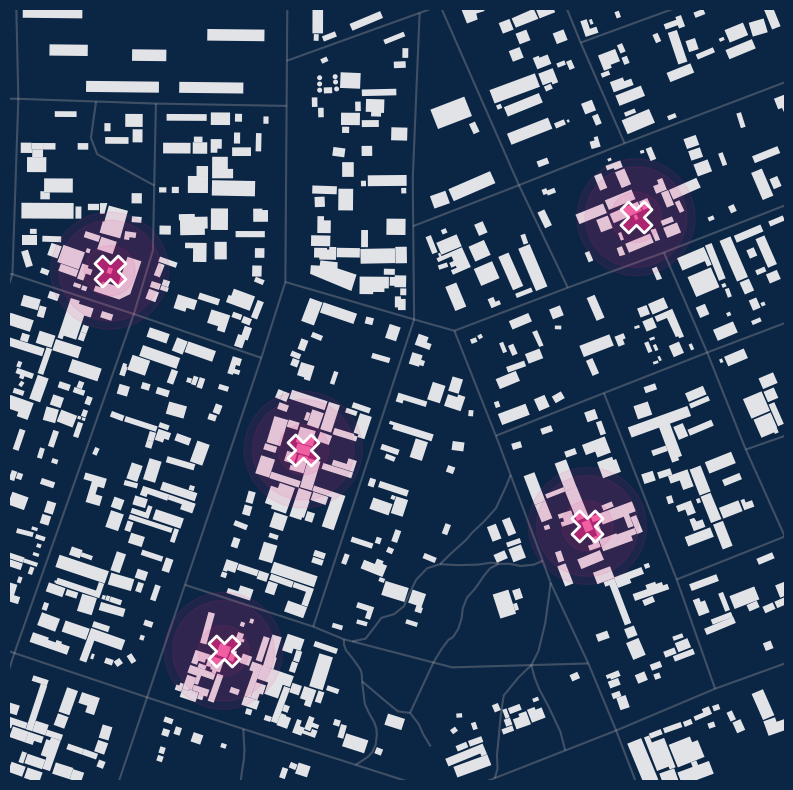

In [10]:
(fig, ax) = (
    plt.figure(figsize=(10, 10), facecolor=STYLE_BG['color']), 
    plt.axes(projection=ccrs.PlateCarree())
)
G = ox.project_graph(NTW, to_crs=ccrs.PlateCarree())
(fig, ax) = ox.plot_graph(
    G, ax, node_size=0, figsize=(40, 40), show=False,
    bgcolor=STYLE_BG['color'], edge_color=STYLE_RD['color'], 
    edge_alpha=STYLE_RD['alpha'], edge_linewidth=STYLE_RD['width']
)
(fig, ax) = ox.plot_footprints(
    BLD, ax=ax, save=False, show=False, close=False,
    bgcolor=STYLE_BG['color'], color=STYLE_BD['color'], 
    alpha=STYLE_BD['alpha']
)
lnd.plotTraps(
    fig, ax, 
    size=500, zorders=(30, 25), transparencyHex='99', 
    proj=ccrs.PlateCarree()
)
srv.plotClean(fig, ax, bbox=BBOX)
ax.set_facecolor(STYLE_BG['color'])
fig.savefig(
    os.path.join(OUT_PTH, '{}.png'.format(ID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=150
)

<hr>

# More Information

* [OSMnx Documentation](https://osmnx.readthedocs.io/)
* [OpenStreetMap](https://www.openstreetmap.org)
